In [1]:
%pylab inline
from bigfile import BigFile

import numpy as np
from matplotlib import pyplot as plt

# A customized tool for visaulize SPH simulations from Gadget 
# https://github.com/rainwoodman/gaepsi
from gaepsi2 import painter
from gaepsi2 import color
from gaepsi2 import camera


import warnings
warnings.filterwarnings("ignore")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc("xtick", labelsize=15)  # fontsize of the tick labels
plt.rc("ytick", labelsize=15)
plt.rcParams["axes.linewidth"] = 1.5  # set the value globally
plt.rcParams["font.family"] = "serif"


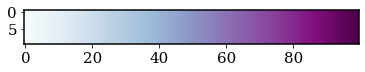

In [3]:
# Import the required matplotlib components for color mapping.
import matplotlib as mpl


# This class helps with creating and using color maps from Matplotlib.
class MplColorHelper:
    def __init__(self, cmap_name, start_val, stop_val):
        # Store the name of the color map.
        self.cmap_name = cmap_name
        # Get the color map from matplotlib's available color maps.
        self.cmap = plt.get_cmap(cmap_name)
        # Normalize the color map between the start and stop values.
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        # Create a ScalarMappable object which will map values to colors.
        self.scalarMap = mpl.cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    # Method to get the RGB color for a given value.
    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)


# Generate an array of 100 linearly spaced values between 0 and 1.
y = np.linspace(0, 1, 100)
# Create an instance of MplColorHelper with the "BuPu" colormap, ranging from 0 to 1.
COL = MplColorHelper("BuPu", 0, 1)

# Apply the color map to the array of values 'y' to get the corresponding RGB values.
x = COL.get_rgb(y)
# Create a colormap object using the RGB values.
dmmap = color.Colormap(x[:, 0:3])

# ---- Visualization Section ----
# Expand the 'x' array to 2D by adding a new axis, and then repeat it 10 times along the new axis.
z = np.expand_dims(x, axis=0)
z = np.repeat(z, 10, axis=0)
# Display the colormap using imshow. This creates a visual representation of the colormap.
plt.imshow(z)

## Visualizing MP-Gadget (Dark Matter or Gas) Simulations with Gaepsi2

This standalone notebook provides a simple guidance on visualizing dark matter-only simulations generated by MP-Gadget. While this notebook primarily focuses on dark matter and gas particle simulations, its methodologies and techniques can be adapted to visualize other types of particles, including stars and black holes.


In [4]:
def cut_tube(part, tube, partition=100):
    """
    This function reads a subset of a particle file to conserve memory usage.

    Parameters:
    part (Bigfile): The input particle file. This file can be opened using part.open("Position")[:].
                    It is read from Bigfile.File("path/to/PART").
    tube (dict): Parameters for the tube, including resolution, wt, Lx, Ly, Lz, and imsize.
    partition (int): The number of partitions to divide the file into for memory-efficient reading.
                     This is helpful when dealing with large particle position files.

    Returns:
    tuple: A tuple containing the full mask and the processed particle positions (ppos).
    """

    # Initialize an empty list to store particle positions.
    ppos_list = []

    # Get the total number of positions to determine batch sizes for partitioning.
    size = part.open("Position").size

    # Create a mask array initialized with zeros. This mask will be used later.
    full_mask = np.zeros((size,), dtype=np.bool_)

    # Calculate the batch size for each partition.
    batch = size // partition

    # Process each partition.
    for i in range(partition):
        # Define start and end indices for the current batch.
        istart = i * batch
        iend = (i + 1) * batch

        # Load a chunk of positions, converting data type to float64 for memory efficiency.
        ppos = np.float64(part.open("Position")[istart:iend])

        # Adjust positions relative to the tube's center.
        ppos -= tube["center"]
        boxsize = tube["Lbox"]

        # Apply periodic boundary conditions to ensure particles wrap around the box correctly.
        ppos[ppos < -boxsize / 2] += boxsize
        ppos[ppos > boxsize / 2] -= boxsize

        # Create a mask to filter particles based on their positions within the tube dimensions.
        mask = np.abs(ppos[:, 0]) < tube["Lx"] * 0.5
        mask &= np.abs(ppos[:, 1]) < tube["Ly"] * 0.5
        mask &= np.abs(ppos[:, 2]) < tube["Lz"] * 0.5

        # Update the full mask with the current batch's mask.
        full_mask[istart:iend] = mask

        # Append the filtered positions to the list and free memory.
        ppos_list.append(ppos[mask])
        del ppos, mask

    # Concatenate all filtered positions into a single array.
    ppos = np.concatenate(ppos_list)

    return full_mask, ppos


def getcorner(tube, theta, ct_scale, r, z):
    """
    Calculates the list of linked corner positions in image size coordinates based on the given parameters.

    Parameters:
    tube (dict): Contains tube parameters including Lx, Ly, Lz, and imsize.
    theta (float): Angle in radians, used for calculating corner positions.
    ct_scale (float): Scale factor for the camera transformation.
    r (float): Radius used for the position calculation.
    z (float): Z-coordinate for the position calculation.

    Returns:
    list: A list of linked corner positions in image size coordinates.
    """
    # Normalize the angle to ensure it is within 0 to 2π range.
    theta = np.mod(theta, 2 * np.pi)

    # Extract and scale the dimensions of the tube.
    Lx, Ly, Lz = tube["Lx"] * 1.0, tube["Ly"] * 1.0, tube["Lz"] * 1.0
    # Determine the largest dimension for further calculations.
    lgt = 0.5 * np.max([Lx, Ly, Lz])
    # Image size from the tube parameters.
    imsize = tube["imsize"]

    # Calculate x and y coordinates based on the radius and angle.
    x, y = r * np.cos(theta), r * np.sin(theta)
    # Calculate the camera transformation scale.
    ct = lgt * ct_scale

    # Set up the orthogonal projection matrix for the camera.
    mpers = camera.ortho(-ct, ct, (-ct, ct, -ct, ct))
    # Set up the model-view matrix to look at the target from a specific position.
    mmv = camera.lookat((x * lgt, y * lgt, z * lgt), (0, 0, 0), (0, 0, 1))

    # Define the coordinates of the corners of a box.
    corner = np.array(
        [
            # Corner coordinates are defined relative to the center.
            [-Lx * 0.5, -Ly * 0.5, -Lz * 0.5],  # 0
            [-Lx * 0.5, -Ly * 0.5, +Lz * 0.5],  # 1
            [-Lx * 0.5, +Ly * 0.5, -Lz * 0.5],  # 2
            [-Lx * 0.5, +Ly * 0.5, +Lz * 0.5],  # 3
            [+Lx * 0.5, -Ly * 0.5, -Lz * 0.5],  # 4
            [+Lx * 0.5, -Ly * 0.5, +Lz * 0.5],  # 5
            [+Lx * 0.5, +Ly * 0.5, -Lz * 0.5],  # 6
            [+Lx * 0.5, +Ly * 0.5, +Lz * 0.5],
        ]
    )  # 7

    # Apply the camera matrices to transform the corner coordinates into 2D.
    corner2d = camera.apply(camera.matrix(mpers, mmv), corner)
    # Transform the 2D coordinates for rendering on the device (e.g., screen).
    cornerdev = camera.todevice(corner2d, extent=(imsize, imsize))

    # Determine the dashed corner based on the theta value.
    if 0 <= theta < np.pi / 2:
        dash_corner = cornerdev[0]
    elif np.pi / 2 <= theta < np.pi:
        dash_corner = cornerdev[4]
    elif np.pi <= theta < 1.5 * np.pi:
        dash_corner = cornerdev[6]
    elif 1.5 * np.pi <= theta < 2 * np.pi:
        dash_corner = cornerdev[2]

    # Initialize an empty list to store the 2D corner coordinates.
    cn2d = []
    for i in range(0, len(cornerdev)):
        p = cornerdev[i]
        # Calculate the difference relative to other corners.
        dr = corner - corner[i]
        # Find the nearest corner for creating an edge.
        msk = np.count_nonzero(dr, axis=-1) == 1
        for o in cornerdev[msk]:
            # Create and append the line coordinates to the list.
            x, y = np.array([p[0], o[0]]), np.array([p[1], o[1]])
            # Calculate distances to determine if the line should be dashed or solid.
            r2 = np.linalg.norm(o - dash_corner, axis=0)
            r3 = np.linalg.norm(p - dash_corner, axis=0)
            if r2 < 1 or r3 < 1:
                cn2d.append([x, y, 0])  # Dashed line
            else:
                cn2d.append([x, y, 1])  # Solid line
    return cn2d

In [5]:
def get_dmonly_channel(
    filename,
    tube,
    theta,
    ct_scale,
    r,
    z,
    use_input_pos_mask: bool = False,
    pos: np.ndarray = None,
):
    """
    Calculate density image channel based on given file.

    Parameters:
    filename (str): Particle file, assumed Gas particle.
    tube (dict): Tube parameters including resolution, wt, Lx, Ly, Lz, and imsize.
    theta (float): Angle in radians.
    ct_scale (float): Control the distance from the camera to the box.
    r (float): Radial coordinate.
    z (float): Z-coordinate.
    use_input_pos_mask (bool): Flag to use input position and mask (optimization).
    pos (np.ndarray): Optional array of positions.

    Returns:
    list: List containing temperature and density image channels.
    """

    # Load particle data from file.
    part = BigFile(filename)

    # If using input position mask, skip cutting tube to save time.
    if use_input_pos_mask:
        print("Use input pos and mask instead (saving iteration time)")
    else:
        print("Start cutting ...")
        # Cut the tube from the particle field to get the mask and positions.
        mask, pos = cut_tube(part, tube)

    # ------- Image Channel Processing -------

    # Set the smoothing length and weight for each particle.
    sml = np.ones(len(pos)) * tube["resolution"]
    weight = np.ones(len(pos)) * tube["wt"]

    # Determine the maximum dimension from the tube for camera positioning.
    Lx, Ly, Lz = tube["Lx"] * 1.0, tube["Ly"] * 1.0, tube["Lz"] * 1.0
    lgt = 0.5 * np.max([Lx, Ly, Lz])
    # Image size from the tube parameters.
    imsize = tube["imsize"]

    # Calculate camera position based on input parameters.
    x, y = r * np.cos(theta), r * np.sin(theta)
    ct = lgt * ct_scale

    # Set up the camera's projection matrix.
    print("Define the projection matrix for the camera ...")
    mpers = camera.ortho(-ct, ct, (-ct, ct, -ct, ct))  # Orthographic projection matrix.

    # Set up the camera's model-view matrix.
    print("Define the modelview matrix for the camera ...")
    mmv = camera.lookat(
        (x * lgt, y * lgt, z * lgt), (0, 0, 0), (0, 0, 1)
    )  # Camera's viewpoint.

    # Transform data coordinates to clip coordinates using camera matrices.
    print(
        "Apply the camera matrix to the data coordinates to obtain position in clip coordinates ..."
    )
    gas2d = camera.apply(camera.matrix(mpers, mmv), pos)

    # Convert clip coordinates to device coordinates for rendering.
    print("Convert the clipping coordinates to device coordinates ...")
    gasdev = camera.todevice(gas2d, extent=(imsize, imsize))

    # Use a painting algorithm to create the image channels from the device coordinates.
    channels = painter.paint(gasdev, sml, [weight], (imsize, imsize), np=8)

    # Normalize and adjust image channels if necessary.
    # channels[1] /= channels[0]

    # Transpose the channels to correct the orientation.
    channels[0] = np.transpose(channels[0])
    # channels[1] = np.transpose(channels[1])

    return channels

In [6]:
def plot_dmonly(
    ax,
    file,
    tube,
    theta,
    twochannel=False,
    frameon=True,
    f1_low=2,  # Not used for DM-only
    f1_high=6,  # Not used for DM-only
    f0_low=None,
    f0_high=None,
    ct_scale=1.45,
    r=2,
    z=0.3,
    use_input_pos_mask: bool = False,
    pos: np.ndarray = None,
    mask: np.ndarray = None,
):
    """
    Plot a dark matter (DM) only simulation based on input parameters.

    Parameters:
    ax (matplotlib.axes.Axes): The Axes object for the plot.
    file: Particle data file read by BigFile.
    tube (dict): Parameters for cutting the tube from the particle field.
    theta (float): Angle in radians for the view direction.
    twochannel (bool, optional): Use two image channels if True. Default is False.
    frameon (bool, optional): Draw a frame around the plot if True. Default is True.
    f1_low, f1_high (float, optional): Range limits for the second channel. Defaults are 2 and 6.
    f0_low, f0_high (float, optional): Range limits for the first channel. Default is None (auto-calculated).
    ct_scale (float, optional): Scale factor for camera distance. Default is 1.45.
    r (float, optional): Radial coordinate for the camera. Default is 2.
    z (float, optional): Z-coordinate for the camera. Default is 0.3.
    use_input_pos_mask (bool, optional): Use provided position and mask. Default is False.
    pos, mask (np.ndarray, optional): Position and mask arrays. Default is None.

    Returns:
    tuple: Tuple containing the image and channel data.
    """

    # Generate image channels based on the DM only data file.
    print("Cutting the file in tube (subset)")
    channel = get_dmonly_channel(
        file,
        tube,
        theta,
        ct_scale,
        r,
        z,
        use_input_pos_mask,
        pos,
    )
    imsize = tube["imsize"]

    # Processing image data for visualization.
    xx = channel[0][channel[0] > 0]
    # Auto-calculate f0 range if not provided.
    if f0_low is None:
        f0_low = np.log10(np.percentile(xx, 25))
    if f0_high is None:
        f0_high = np.log10(np.percentile(xx, 90))

    print("f0_low = %.2f" % f0_low, "f0_high = %.2f" % f0_high)

    # Create the image for plotting, based on whether two channels are used.
    if twochannel:
        img = color.CoolWarm(
            color.NL(channel[1], range=(f1_low, f1_high)),
            color.NL(channel[0], range=(f0_low, f0_high)),
        )
    else:
        channels1 = np.ones([imsize, imsize]) * 1e5
        img = dmmap(
            color.NL(channels1, range=(4.4, 5.5)),
            color.NL(channel[0], range=(f0_low, f0_high)),
        )

    # Plotting the image on the provided Axes object.
    ax.imshow(img, origin="lower", extent=(0, imsize, 0, imsize))

    # Adding a frame around the plot if frameon is True.
    if frameon:
        box = getcorner(tube, theta, ct_scale, r, z)
        for d in box:
            x, y, m = d
            # Choose linestyle based on the value of 'm'.
            if m == 0:
                ax.plot(x, y, c="grey", alpha=0.5, lw=1, linestyle="--")
            if m == 1:
                ax.plot(x, y, c="C0", lw=1.5, alpha=0.7)

    # Set plot limits and remove axis ticks for a cleaner look.
    ax.set_xlim(0, imsize)
    ax.set_ylim(0, imsize)
    ax.set_xticks([])
    ax.set_yticks([])

    return img, channel

## Dark-Matter Only Simulations


In [7]:
# Partcile files of the simulations

# The file path for dark matter (DM) particles in the '1' folder of the 'PART_008' dataset.
file_l1 = "/bigdata/birdlab/mho026/SimulationRunnerGalaxy/data/low_fullphysics_50/test-128-60-fullphysics_0000/output/PART_031/1/"

# Define a dictionary 'tube_l1' containing parameters for visualizing a subset of the simulation.
tube_l1 = {
    "Lbox": 60000,  # The side length of the entire simulation box in kpc. Equivalent to 60 cMpc/h.
    "center": np.array(
        [0, 0, 0]
    ),  # The center point of the subset box in the 3D image, here set to the origin.
    "Lx": 60000,  # The x-dimension size of the subset of the simulation to visualize, in kpc. Also 60 cMpc/h.
    "Ly": 60000,  # The y-dimension size, similar to 'Lx'.
    "Lz": 60000,  # The z-dimension size, similar to 'Lx'.
    "imsize": 1000,  # The size of the interpolation grid. Determines the resolution of the output image.
    "resolution": 5,  # The resolution of the visualization. Related to the SPH (Smoothed Particle Hydrodynamics) smoothing length.
    "wt": 1.0
    / 128,  # Normalization weighting factor for SPH interpolation. Used to adjust the influence of each particle.
}

In [8]:
# L1 cutting: cutting a subset of the simulation for visualization.
# In this case, we don't actually cut the simulation because it's small enough to handle as is.

# Load the particle data from the specified file using the BigFile module.
# This step involves reading the DM particle data from the file path provided in 'file_l1'.
part = BigFile(file_l1)

# Use the 'cut_tube' function to extract a subset of the particle positions from the simulation.
# This subset is defined by the parameters in 'tube_l1', such as size and center of the desired region.
# The function returns a mask indicating the particles in the subset and their positions.
mask_l1, ppos_l1 = cut_tube(part, tube_l1)

# Optional: Save the cut particle positions to a file for later use.
# This is a helpful step if 'cut_tube' takes a long time to process, allowing you to quickly reload the data in future sessions.
# np.save("ppos_l1_test0.npy", ppos_l1)

L1 plotting


Cutting the file in tube (subset)
Use input pos and mask instead (saving iteration time)
Define the projection matrix for the camera ...
Define the modelview matrix for the camera ...
Apply the camera matrix to the data coordinates to obtain position in clip coordinates ...
Convert the clipping coordinates to device coordinates ...
f0_low = -2.36 f0_high = -1.36


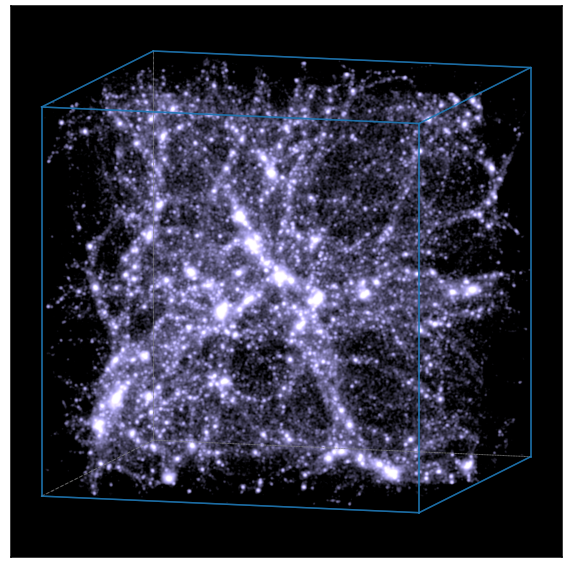

In [9]:
f, ax = plt.subplots(1, 1, figsize=[8, 8])

img, channel = plot_dmonly(
    ax,
    file_l1,
    tube_l1,
    frameon=True,
    ct_scale=1.4,
    theta=5.0,
    z=0.3,
    use_input_pos_mask=True,
    pos=ppos_l1,
)

plt.tight_layout()

# In case you want to save into image file
# plt.savefig("DMONLY-L1-0.1.png", bbox_inches="tight", dpi=150)


## Visualization of Gas Particles Color-Coded by Temperature

To create this visualization, access the MP-Gadget output, specifically the "0" folder located within the "PART" directory. This folder contains the necessary data for our visualization - the positions of gas particles and their corresponding internal energies, which represent temperatures. We'll use this data to generate a two-channel image where the density field of gas particles is color-coded based on their temperature.


In [10]:
def get_tem_dens_channel(
    filename,
    tube,
    theta,
    ct_scale,
    r,
    z,
    use_input_pos_mask=False,
    pos=None,
    mask=None,
    use_input_gasen=True,
    gasen=None,
    num_processors=8,
):
    """
    Calculates temperature and density image channels from a given particle data file.

    Parameters:
    filename (str): Path to the particle data file, assumed to be a Gas particle file.
    tube (dict): Parameters for the 'tube' in which the data is visualized, including dimensions and image size.
    theta (float): Angle of the viewpoint in radians.
    ct_scale (float): Scaling factor to control the distance from the camera to the visualization box.
    r (float): Radial distance for the camera position.
    z (float): Z-coordinate for the camera position.
    use_input_pos_mask (bool): If True, uses the provided position and mask arrays instead of cutting them again.
    pos (np.ndarray): Array of positions, used if use_input_pos_mask is True.
    mask (np.ndarray): Mask array, used if use_input_pos_mask is True.
    use_input_gasen (bool): If True, uses the provided gas internal energy array instead of extracting it again.
    gasen (np.ndarray): Array of gas internal energies, used if use_input_gasen is True.
    num_processors (int): Number of processors to use for parallel processing.

    Returns:
    list: List containing arrays of temperature and density image channels.
    """
    part = BigFile(filename)

    # Extract a subset of the particle field as specified by 'tube'.
    if not use_input_pos_mask:
        print("Start cutting ...")
        mask, pos = cut_tube(part, tube)

    # Use provided gas energy data or extract it from the particle data.
    if not use_input_gasen:
        print("Open gas energy ...")
        gasen = part.open("InternalEnergy")[:][mask]

    # Initialize smoothing lengths and weights for the particles.
    sml = np.ones(len(pos)) * tube["resolution"]
    weight = np.ones(len(pos)) * tube["wt"]

    # Calculate camera-related dimensions and position.
    Lx, Ly, Lz = tube["Lx"], tube["Ly"], tube["Lz"]
    lgt = 0.5 * np.max([Lx, Ly, Lz])
    imsize = tube["imsize"]
    x, y = r * np.cos(theta), r * np.sin(theta)
    ct = lgt * ct_scale

    # Define the projection and modelview matrices for the camera.
    print("Setting up camera matrices ...")
    mpers = camera.ortho(-ct, ct, (-ct, ct, -ct, ct))
    mmv = camera.lookat((x * lgt, y * lgt, z * lgt), (0, 0, 0), (0, 0, 1))

    # Apply camera matrices to convert data coordinates to clip coordinates.
    print("Applying camera matrices ...")
    gas2d = camera.apply(camera.matrix(mpers, mmv), pos)

    # Convert clip coordinates to device coordinates for visualization.
    print("Converting to device coordinates ...")
    gasdev = camera.todevice(gas2d, extent=(imsize, imsize))

    # Generate image channels.
    channels = painter.paint(
        gasdev, sml, [weight, weight * gasen], (imsize, imsize), np=num_processors
    )

    # Normalize and transpose the channels for correct orientation.
    channels[1] /= channels[0]
    channels[0] = np.transpose(channels[0])
    channels[1] = np.transpose(channels[1])

    return channels


def plot_hydro(
    ax,
    file,
    tube,
    theta,
    twochannel=True,
    frameon=True,
    axis=1,
    f1_low=None,
    f1_high=None,
    f0_low=None,
    f0_high=None,
    ct_scale=1.45,
    r=2,
    z=0.3,
    use_input_pos_mask=False,
    pos=None,
    mask=None,
    use_input_gasen=True,
    gasen=None,
    color_frame="red",
    num_processors=8,
):
    """
    Plots a hydrodynamic simulation, such as a Lyman-alpha tube, based on the provided parameters.

    Parameters:
        ax (matplotlib.axes.Axes): The Axes object to draw the plot on.
        file: The file path to the particle data, read by BigFile.
        tube (dict): Dictionary containing parameters to define the 'tube' subset in the simulation.
        theta (float): View angle in radians.
        twochannel (bool): If True, uses two image channels (default is True).
        frameon (bool): If True, draws a frame around the plot (default is True).
        axis (int): Specifies the axis along the line of sight (default is 1).
        f1_low, f1_high (float): Lower and upper limits for the second channel's range.
        f0_low, f0_high (float): Lower and upper limits for the first channel's range.
        ct_scale (float): Factor to control the distance from the camera to the box.
        r (float): Radial coordinate for camera positioning.
        z (float): Z-coordinate for camera positioning.
        use_input_pos_mask (bool): If True, uses provided position and mask arrays.
        pos (np.ndarray): Position array, used if use_input_pos_mask is True.
        mask (np.ndarray): Mask array, used if use_input_pos_mask is True.
        use_input_gasen (bool): If True, uses provided gas energy data.
        gasen (np.ndarray): Gas energy data array, used if use_input_gasen is True.
        color_frame (str): Color of the frame around the plot.
        num_processors (int): Number of processors to use for computation.

    Returns:
        numpy.ndarray: The final cropped image for the plot.
    """

    # Extract temperature and density channels from the data.
    print("Extracting data for visualization...")
    channel = get_tem_dens_channel(
        file,
        tube,
        theta,
        ct_scale,
        r,
        z,
        use_input_pos_mask,
        pos,
        mask,
        use_input_gasen,
        gasen,
        num_processors,
    )
    imsize = tube["imsize"]

    # Determine dynamic range for visualization.
    xx = channel[0][channel[0] > 0]
    f0_low = np.log10(np.percentile(xx, 3)) if f0_low is None else f0_low
    f0_high = np.log10(np.percentile(xx, 97)) if f0_high is None else f0_high
    print(f"f0_low = {f0_low:.2f}, f0_high = {f0_high:.2f}")
    yy = channel[1][channel[1] > 0]
    f1_low = np.log10(np.percentile(yy, 3)) if f1_low is None else f1_low
    f1_high = np.log10(np.percentile(yy, 97)) if f1_high is None else f1_high
    print(f"f1_low = {f1_low:.2f}, f1_high = {f1_high:.2f}")

    # Apply color mapping based on channel information.
    if twochannel:
        img = color.CoolWarm(
            color.NL(channel[1], range=(f1_low, f1_high)),
            color.NL(channel[0], range=(f0_low, f0_high)),
        )
    else:
        channels1 = np.ones([imsize, imsize]) * 1e5
        img = dmmap(
            color.NL(channels1, range=(4.4, 5.5)),
            color.NL(channel[0], range=(f0_low, f0_high)),
        )

    # Plotting the image on the provided Axes object.
    ax.imshow(img, origin="lower", extent=(0, imsize, 0, imsize))

    # Adding a frame around the plot if frameon is True.
    if frameon:
        box = getcorner(tube, theta, ct_scale, r, z)
        for d in box:
            x, y, m = d
            # Choose linestyle based on the value of 'm'.
            if m == 0:
                ax.plot(x, y, c="grey", alpha=0.5, lw=1, linestyle="--")
            if m == 1:
                ax.plot(x, y, c="C0", lw=1.5, alpha=0.7)

    # Set plot limits and remove axis ticks for a cleaner look.
    ax.set_xlim(0, imsize)
    ax.set_ylim(0, imsize)
    ax.set_xticks([])
    ax.set_yticks([])

    return img

In [11]:
# Field "0" for the gas particles
file_hr = "/bigdata/birdlab/mho026/SimulationRunnerGalaxy/data/low_fullphysics_50/test-128-60-fullphysics_0000/output/PART_031/0/"

part_hr = BigFile(file_hr)

# Define a dictionary 'tube_hr' containing parameters for visualizing a subset of the simulation.
tube_hr = {
    "Lbox": 60000,  # The side length of the entire simulation box in kpc. Equivalent to 60 cMpc/h.
    "center": np.array(
        [0, 0, 0]
    ),  # The center point of the subset box in the 3D image, here set to the origin.
    "Lx": 60000,  # The x-dimension size of the subset of the simulation to visualize, in kpc. Also 60 cMpc/h.
    "Ly": 60000,  # The y-dimension size, similar to 'Lx'.
    "Lz": 60000,  # The z-dimension size, similar to 'Lx'.
    "imsize": 1000,  # The size of the interpolation grid. Determines the resolution of the output image.
    # play around with resolution to make prettier viz
    "resolution": 5,  # The resolution of the visualization. Related to the SPH (Smoothed Particle Hydrodynamics) smoothing length.
    "wt": 1.0
    / 128,  # Normalization weighting factor for SPH interpolation. Used to adjust the influence of each particle.
}


mask_hr, ppos_hr = cut_tube(
    part_hr,
    tube_hr,
)
gasen_hr = part_hr.open("InternalEnergy")[:][mask_hr]

Extracting data for visualization...
Setting up camera matrices ...
Applying camera matrices ...
Converting to device coordinates ...
f0_low = -3.74, f0_high = -0.99
f1_low = 2.00, f1_high = 7.00


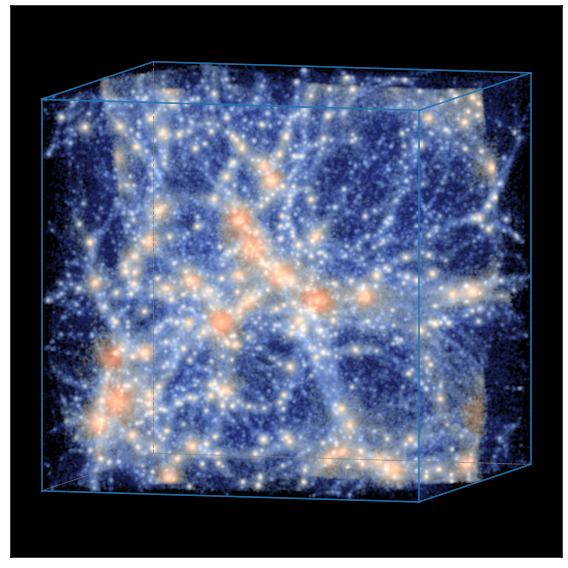

In [12]:
f, ax = plt.subplots(1, 1, figsize=[8, 8])

img = plot_hydro(
    ax,
    file_hr,
    tube_hr,
    frameon=True,
    twochannel=True,
    ct_scale=1.4,
    f1_low=2,  # play around with this to make prettier viz
    f1_high=7,  # play around with this to make prettier viz
    theta=5.0,
    z=0.2,
    use_input_pos_mask=True,
    mask=None,
    pos=ppos_hr,
    use_input_gasen=True,
    gasen=gasen_hr,
    num_processors=4,
)
# ax.text(0.02, 0.5, "Hydro", fontsize=16, c="orange", transform=ax.transAxes)
plt.tight_layout()